<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Traductor
Ejemplo basado en [LINK](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/)

### Consignas
Replicar y extender el traductor:
- Replicar el modelo en PyTorch.
- Extender el entrenamiento a más datos y tamaños de
secuencias mayores.
- Explorar el impacto de la cantidad de neuronas en
las capas recurrentes.
- Mostrar 5 ejemplos de traducciones generadas.
- Extras que se pueden probar: Embeddings
pre-entrenados para los dos idiomas; cambiar la
estrategia de generación (por ejemplo muestreo
aleatorio);

### Datos
El objetivo es utilizar datos disponibles del Tatoeba Project de traducciones de texto en diferentes idiomas.  
Se construirá un modelo traductor de inglés a español seq2seq utilizando encoder-decoder.  
[LINK](https://www.manythings.org/anki/)

In [1]:
import requests
import os
from zipfile import ZipFile
import numpy as np

In [2]:
# Funcion auxiliar para descargar el dataset
def download_dataset(dataset_url: str, target_dir: str, check_dir: str | None = None, force: bool = False, tmp_file: str = "tmp.zip", unzip: bool = True):

    if check_dir and os.path.isdir(check_dir) and not force:
        print("Check folder already exists, nothing downloaded.")
        return

    try:
        with requests.get(dataset_url, stream=True, allow_redirects=True) as response:
            response.raise_for_status()  # Raise an exception for bad status codes

            with open(tmp_file, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
        print(f"File '{tmp_file}' downloaded successfully.")
    except requests.exceptions.RequestException as e:
        if (os.path.isfile(tmp_file)):
            os.remove(tmp_file)
        raise(Exception(f"Error downloading file: {e}"))

    if not unzip:
        return
    try:
        with ZipFile(tmp_file, 'r') as zip_object:
            zip_object.extractall(target_dir)
        print(f"Successfully extracted '{tmp_file}' to '{target_dir}'.")

    except FileNotFoundError:
        raise(Exception(f"Error: The file '{tmp_file}' was not found."))
    except Exception as e:
        raise(Exception(f"An error occurred: {e}"))
    finally:
        if (os.path.isfile(tmp_file)):
            os.remove(tmp_file)


Descarga del dataset con traducciones

In [3]:
dataset_url = "http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
base_dir = "./"
folder_dir = "spa-eng"
download_dataset(dataset_url, base_dir, check_dir=folder_dir, tmp_file="spa-eng.zip")

Check folder already exists, nothing downloaded.


Establezco límite para las oraciones de entrada y salida.  
En salida uso un valor ligeramente superior porque el idioma español suele tener mas palabras para las mismas oraciones.

In [4]:
# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada y salida
max_input_len = 8
max_out_len = 12

In [5]:
# dataset_file

text_file = os.path.join(base_dir, folder_dir, "spa.txt")
with open(text_file, encoding="utf8") as f:
    lines = f.read().split("\n")[:-1]

input_sentences = []
output_sentences = []
output_sentences_inputs = []
count = 0

for line in lines:
    # el tabulador señaliza la separación entre las oraciones 
    # en ambos idiomas
    if '\t' not in line: 
        continue

    # Input sentence --> eng
    # output --> spa
    input_sentence, output = line.rstrip().split('\t')

    # Limito las longitudes de sentencias
    if (len(input_sentence.split(" ")) > max_input_len) \
        or (len(output.split(" ")) > max_out_len):
        continue

    # output sentence (decoder_output) tiene <eos>
    output_sentence = output + ' <eos>'
    # output sentence input (decoder_input) tiene <sos>
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 98654


In [6]:
import random
# Solo me quedo con una fracción de textos
MAX_NUM_SENTENCES = 80000

random.seed(42)
rnd_idx = random.sample(range(len(input_sentences)), min(MAX_NUM_SENTENCES, len(input_sentences))) # Al azar
# rnd_idx = range(min(MAX_NUM_SENTENCES, len(input_sentences))) # Primeros n
input_sentences = [input_sentences[i] for i in rnd_idx]
output_sentences = [output_sentences[i] for i in rnd_idx]
output_sentences_inputs = [output_sentences_inputs[i] for i in rnd_idx]

Visualizo un ejemplo de las oraciones de entrada y de salida

In [7]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0], len(input_sentences)

('Tom sometimes falls asleep in class.',
 'Tom a veces se queda dormido en clases. <eos>',
 '<sos> Tom a veces se queda dormido en clases.',
 80000)

### 2 - Preprocesamiento

In [8]:
from collections import Counter
# Tokenizar las palabras, similar a Tokenizer de Keras
class Tokenizer():
    def __init__(self, num_words: int | None = None, filters: str = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
        self.num_words = num_words - 1 if num_words else None # Reservo el indice 0 para padding
        self.filters = filters
        self.word_index = {}

    def __preprocess_text(self, text: str) -> list[str]:
        # Quito caracteres especiales y paso todo a minusculas
        text = ''.join(' ' if char in self.filters else char for char in text.lower())
        return [word for word in text.split(' ') if word]

    def fit_on_texts(self, input_sentences: list[str], force_include: list[str] = []) -> None:
        if (len(self.word_index) != 0):
            raise(Exception("Tokenizer has already been fit."))
        # Guardo cantidad de apariciones de cada palabra
        counter = Counter()
        for text in input_sentences:
            sentence = self.__preprocess_text(text)
            if not sentence: continue
            counter.update(sentence)

        # Selecciono las más comunes, si es que se indica máximo
        most_common_n_words = counter.most_common(self.num_words)
        # Fuerzo la inclusion de ciertas palabras
        # ya que podrían quedar fuera por no se tan comunes
        # (pasa con <eos> ya que se fittea con las frases que no lo contienen)
        for forced in reversed(force_include):
            if forced not in tuple(zip(*most_common_n_words))[0]:
                most_common_n_words.insert(0, (forced, 0))
        # Si se insertó alguna palabra forzada tengo que volver
        # a quedarme con las N mas comunes (o todas si no se indica)
        most_common_n_words = most_common_n_words[:self.num_words]
        # Calculamos indices para cada palabra, empezando en 1 (igual que Keras)
        self.word_index = { word: i+1 for i, (word, _) in enumerate(most_common_n_words)}

    def texts_to_sequences(self, input_sentences: list[str]):
        if (len(self.word_index) == 0):
            raise(Exception("Tokenizer has not been fit yet."))
        input_integer_seq = []
        for tokens in input_sentences:
            tokens = self.__preprocess_text(tokens)
            if not tokens: continue
            sequence = [self.word_index[word] for word in tokens if word in self.word_index]
            input_integer_seq.append(sequence)
        return input_integer_seq

In [9]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 15000
# Vamos a necesitar un tokenizador para cada idioma

In [10]:
# tokenizador de inglés
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 10933
Sentencia de entrada más larga: 10


La entrada mas larga es de 10 porque al separar las palabras por los filtros de caracteres se pueden generar mas que el límite establecido inicialmente.  
Visualizamos las palabras y el index asociado.

In [11]:
word2idx_inputs

{'i': 1,
 'the': 2,
 'you': 3,
 'to': 4,
 'tom': 5,
 'a': 6,
 'is': 7,
 'he': 8,
 'in': 9,
 'this': 10,
 'it': 11,
 'do': 12,
 'was': 13,
 'me': 14,
 'my': 15,
 'of': 16,
 'have': 17,
 'that': 18,
 'she': 19,
 'are': 20,
 "don't": 21,
 'for': 22,
 'what': 23,
 'your': 24,
 'we': 25,
 "i'm": 26,
 'his': 27,
 'mary': 28,
 'want': 29,
 'on': 30,
 'like': 31,
 'be': 32,
 'not': 33,
 'with': 34,
 'know': 35,
 'at': 36,
 'him': 37,
 'can': 38,
 'go': 39,
 'has': 40,
 'did': 41,
 'they': 42,
 'very': 43,
 'her': 44,
 'and': 45,
 'there': 46,
 "it's": 47,
 'here': 48,
 'will': 49,
 'how': 50,
 'all': 51,
 "didn't": 52,
 'about': 53,
 'up': 54,
 "can't": 55,
 'time': 56,
 'an': 57,
 'think': 58,
 'please': 59,
 "you're": 60,
 'get': 61,
 'why': 62,
 'come': 63,
 'had': 64,
 'from': 65,
 "doesn't": 66,
 'no': 67,
 'out': 68,
 'were': 69,
 "i'll": 70,
 'need': 71,
 'good': 72,
 'as': 73,
 'see': 74,
 'where': 75,
 'by': 76,
 'just': 77,
 'going': 78,
 'one': 79,
 'help': 80,
 'now': 81,
 'am': 82

In [12]:
# tokenizador de español
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(output_sentences, force_include=["<sos>", "<eos>"])
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 14999
Sentencia de salida más larga: 14


In [13]:
print(f"Sentencia de entrada más larga: {max_input_len}.")
print(f"Sentencia de salida más larga: {max_out_len}.")

Sentencia de entrada más larga: 10.
Sentencia de salida más larga: 14.


Verifico que el SOS y EOS existan en el tokenizador de salida

In [14]:
for sec in output_tokenizer.texts_to_sequences(["<sos>", "<eos>"]):
    assert sec, "El tokenizador debe incluir <sos> y <eos>"

A la hora de realizar padding es importante tener en cuenta que en el encoder los ceros se agregan al comienzo y en el decoder al final.  
Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [15]:
def pad_sequences(sequences, maxlen=None, dtype='int32', padding_pre=True, value=0.0):
    if maxlen is None:
        maxlen = max(len(s) for s in sequences)

    out_secuences = []
    for secuence in sequences:
        if len(secuence) <= maxlen: # Hago padding hasta max_len
            if padding_pre:
                sec_out = [value] * (maxlen - len(secuence)) + secuence
            else:
                sec_out = secuence + [value] * (maxlen - len(secuence))
        else: # O me quedo con los max_len caracteres
            if padding_pre:
                sec_out = secuence[-maxlen:]
            else:
                sec_out = secuence[:maxlen]
        out_secuences.append(sec_out)

    return np.array(out_secuences, dtype=dtype)

In [16]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding_pre=False)
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 80000
encoder_input_sequences shape: (80000, 10)
decoder_input_sequences shape: (80000, 14)


In [17]:
encoder_input_sequences[0]

array([   0,    0,    0,    0,    5,  563, 2659,  620,    9,  542])

In [18]:
decoder_input_sequences[0]

array([  1,   3,   6, 222,  15, 390, 605,  11, 585,   0,   0,   0,   0,
         0])

In [19]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding_pre=False)
decoder_targets = decoder_output_sequences
decoder_targets.shape

(80000, 14)

In [20]:
decoder_output_sequences[0]

array([  3,   6, 222,  15, 390, 605,  11, 585,   2,   0,   0,   0,   0,
         0])

### 3 - Preparar los embeddings

In [21]:
url = 'https://drive.usercontent.google.com/download?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t&uuid=07c897f9-d9a1-4bdd-8cce-70c9dca2368a&at=AKSUxGMQs76z20Q73h7ULNM9qfje%3A1759553933720'
output = 'gloveembedding.pkl'
if os.access(os.path.join(base_dir, output), os.F_OK) is False:
    download_dataset(url, base_dir, tmp_file=output, unzip=False)
else:
    print(f"Los embeddings {output} ya están descargados")

Los embeddings gloveembedding.pkl ya están descargados


Creo una clase genérica para todos los embeddings, asi puedo pasar por parámetro el que quiera al encoder o decoder sin necesidad de ajustes.

In [22]:
from abc import abstractmethod

# Clase generica para definir los modelos de embeddings
class WordsEmbeddings(object):
    def __init__(self, num_features, word2idx, frozen) -> None:
        self.num_features = num_features
        self.word2idx = word2idx
        self.frozen = frozen
        self.__create_emb_matrix()

    @property
    def get_num_features(self) -> int:
        return self.num_features

    @property
    def get_frozen(self) -> int:
        return self.frozen

    @property
    def get_embedding_matrix(self):
        return self.embedding_matrix
    
    @abstractmethod
    def get_word_embedding(self, word) -> list[float] | None:
        pass

    # Crear la Embedding matrix de las secuencias
    def __create_emb_matrix(self):
        
        print('preparing embedding matrix...')
        words_not_found = []

        nb_words = len(self.word2idx) + 1 # vocab_size
        embedding_matrix = np.zeros((nb_words, self.get_num_features))
        for word, i in self.word2idx.items():
            if i >= nb_words: # se tendrán nb_words-1 words, porque el 0 es para unknown
                break
            embedding_vector = self.get_word_embedding(word)
            if (embedding_vector is not None) and any(v != 0.0 for v in embedding_vector):
                embedding_matrix[i] = embedding_vector
            else:
                # words not found in embedding index will be all-zeros.
                words_not_found.append(word)

        print('number of null word embeddings:', np.sum(np.any(embedding_matrix, axis=1) == 0))
        print(f"Words not found: {words_not_found}")
        self.embedding_matrix = embedding_matrix

In [23]:
import logging
import os
from pathlib import Path
import pickle

# Clase para manejar los embeddings de Glove
class GloveEmbeddings(WordsEmbeddings):
    logger = logging.getLogger(__name__)

    def __init__(self, word2idx, frozen):
        self.PKL_PATH = 'gloveembedding.pkl'
        self.N_FEATURES = 50

        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            raise Exception("Words embedding not available")
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.glove_word2idx = dict(zip(self.embeddings['word'], index))
        self.glove_idx2word = dict(zip(index, self.embeddings['word']))

        super().__init__(self.N_FEATURES, word2idx, frozen)

    def get_word_embedding(self, word) -> list[float] | None:
        word_idx = self.word_2_idx(word)
        return self.embeddings[word_idx]['embedding']

    def word_2_idx(self, word):
        return self.glove_word2idx.get(word, -1)

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

In [24]:
# Clase para manejar embeddings vacios
class Empty_Embeddings(WordsEmbeddings):
    def __init__(self, embedding_size, word2idx) -> None:
        super().__init__(embedding_size, word2idx, frozen=False)

    def get_word_embedding(self, word) -> list[float] | None:
        return None

In [25]:
%pip install --quiet fasttext-wheel
import fasttext.util
# Clase para manejar los embeddings de Fasttext
class Fasttext_Embeddings(WordsEmbeddings):
    def __init__(self, lang, embedding_size, word2idx, frozen) -> None:
        fasttext.util.download_model(lang, if_exists='ignore')
        self.model = fasttext.load_model(f'cc.{lang}.300.bin')
        fasttext.util.reduce_model(self.model, embedding_size)
        super().__init__(self.model.get_dimension(), word2idx, frozen)

    def get_word_embedding(self, word) -> list[float] | None:
        return self.model.get_word_vector(word).tolist()

Note: you may need to restart the kernel to use updated packages.


In [26]:
# Clase concreta para embeddings Fasttext en ingles
class Fasttext_en_Embeddings(Fasttext_Embeddings):
    def __init__(self, embedding_size, word2idx, frozen) -> None:
        super().__init__("en", embedding_size, word2idx, frozen)

# Clase concreta para embeddings Fasttext en español
class Fasttext_es_Embeddings(Fasttext_Embeddings):
    def __init__(self, embedding_size, word2idx, frozen) -> None:
        super().__init__("es", embedding_size, word2idx, frozen)


Cargo los embeddings de entrada y de salida.  
En la clase empty embeddings, como no conoce ninguna palabra, todas tendrán un embedding nulo que deberá entrenarse desde cero.

In [ ]:
embedding_glove_eng = GloveEmbeddings(word2idx_inputs, frozen=True)
# embedding_fasttext_eng = Fasttext_en_Embeddings(100, word2idx_inputs, frozen=True)
# embedding_fasttext_esp = Fasttext_es_Embeddings(100, word2idx_outputs, frozen=True)
embedding_empty_esp = Empty_Embeddings(50, word2idx_outputs)

preparing embedding matrix...
number of null word embeddings: 591
Words not found: ["don't", "i'm", "it's", "didn't", "can't", "you're", "doesn't", "i'll", "i've", "isn't", "that's", "he's", "tom's", "let's", "we're", "what's", "there's", "won't", "i'd", "they're", "couldn't", "wasn't", "mary's", "she's", "haven't", "you'll", "we'll", "aren't", "you've", '30', "shouldn't", "we've", '2', "who's", "wouldn't", "you'd", "where's", "hasn't", "should've", "he'll", "must've", "weren't", "it'll", '10', "today's", '000', "he'd", "how's", "they'll", "father's", "here's", '00', '5', "that'll", '3', "we'd", "mother's", "what're", "one's", "could've", '100', "someone's", "they've", "she'll", "everyone's", '8', "john's", "something's", "hadn't", '20', "would've", "man's", "friend's", "everything's", '2013', "sister's", "son's", '6', '7', "brother's", "people's", '50', '300', "doctor's", '1', "nobody's", "what'll", "uncle's", "grandfather's", "she'd", "daughter's", '500', '40', "driver's", '18', "ain

In [ ]:
# Dimensión de los embeddings de las secuencias
embedding_glove_eng.embedding_matrix.shape, embedding_empty_esp.embedding_matrix.shape

((10934, 50), (10934, 100), (15000, 100), (15000, 50))

### 4 - Entrenar el modelo

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, embedding_model, dropout = 0.2, lstm_size = 128, num_layers = 1):
        super().__init__()
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        embedding_matrix = embedding_model.get_embedding_matrix
        freeze_emb = embedding_model.get_frozen
        self.embedding_dim = embedding_matrix.shape[1]
        
        # El tamaño del embedding lo toma directamente de la matriz que se creó antes
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embedding_matrix).float(), freeze=freeze_emb, padding_idx=0)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=dropout if num_layers != 1 else 0) # LSTM layer
        # Agrego dropout para mejorar el entrenamiento
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        try:
            out = self.dropout(self.embedding(x))
        except Exception:
            print("encoder")
            raise(Exception)
        _, (ht, ct) = self.lstm(out) # Del encoder solo se usa h y c
        return (ht, ct)

idx2word_target = {v:k for k, v in word2idx_outputs.items()}
class Decoder(nn.Module):
    def __init__(self, embedding_model, dropout = 0.2, lstm_size = 128, num_layers = 1):
        super().__init__()
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        embedding_matrix = embedding_model.get_embedding_matrix
        freeze_emb = embedding_model.get_frozen        
        self.embedding_dim = embedding_matrix.shape[1]
        self.output_dim = embedding_matrix.shape[0]

        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embedding_matrix).float(), freeze=freeze_emb, padding_idx=0)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=dropout if num_layers != 1 else 0) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer
        # Agrego dropout para mejorar el entrenamiento
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, prev_state):
        try:
            out = self.dropout(self.embedding(x))
        except Exception as e:
            print(f"decoder {input} - {idx2word_target[x]}")
            raise(e)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        # Con softmax no funciona, la salida pura si
        # out = self.softmax(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        # Sospecho que es porque en CrossEntropyLoss fue necesario (ignore_index=0)
        # y con softmax estamos modificando el 0
        out = self.fc1(lstm_output[:,-1,:])
        return out, (ht, ct)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.lstm_size == decoder.lstm_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, encoder_input, decoder_input, teacher_forcing_ratio):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim
        # tensor para almacenar la salida
        # (batch_size, sentence_len, vocab_size)
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size).to(self.device)
            
        # ultimo hidden state del encoder, primer estado oculto del decoder
        prev_state = self.encoder(encoder_input)
        # En la primera vuelta no tengo predicción previa, por lo que uso el token de <sos>
        # sea teacher forcing o no
        top1 = decoder_input[:, 0:1]

        for t in range(decoder_input_len):
            # t --> token index

            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio

            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = decoder_input[:, t:t+1] if teacher_force else top1

            # ingresar cada token embedding, uno por uno junto al hidden state
            # recibir el output del decoder
            output, prev_state = self.decoder(input, prev_state)

            # guardar cada salida
            outputs[:, t, :] = output

            # get the highest predicted token from our predictions
            top1 = output.argmax(1, keepdim=True)

        return outputs

Creo el dataset

In [30]:
from torch.utils.data import Dataset, DataLoader

class TranslatorDataset(Dataset):
    def __init__(self, encoder_input_sequences, decoder_input_sequences, decoder_targets):
        self.encoder_input_sequences = torch.tensor(encoder_input_sequences, dtype=torch.int)
        self.decoder_input_sequences = torch.tensor(decoder_input_sequences, dtype=torch.int)
        self.decoder_targets = torch.tensor(decoder_targets, dtype=torch.long)

    def __len__(self):
        return len(self.encoder_input_sequences)

    def __getitem__(self, idx):
        return (self.encoder_input_sequences[idx],
                self.decoder_input_sequences[idx],
                self.decoder_targets[idx])

In [31]:
encoder_input_sequences.shape, decoder_input_sequences.shape, decoder_targets.shape

((80000, 10), (80000, 14), (80000, 14))

Separo en train, val y test

In [32]:
from torch.utils.data import random_split

full_dataset = TranslatorDataset(encoder_input_sequences, decoder_input_sequences, decoder_targets)

train_size = int(0.8 * len(full_dataset))  # 80% for training
test_size = len(full_dataset) - train_size  # Remaining 20% for testing
train_dataset, val_dataset = random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

print(f"Train size: {len(train_dataset)}. Validation size: {len(val_dataset)}")

Train size: 64000. Validation size: 16000


Defino batch size y creo el dataloader

In [33]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Calculo de accuracy y función de entrenamiento

In [34]:
def calculate_accuracy(outputs, labels):
    predicted = outputs.argmax(dim=2)
    total = labels.size(0) * labels.size(1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

def train(model, train_loader, valid_loader, optimizer, criterion, device, epochs=20, clip = 1.0, teacher_forcing_ratio = 0.8, model_filename = "model.pt"):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []
    best_valid_loss = float("inf")

    # Defino mi loop de entrenamiento
    model.to(device)
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_encoder_input, train_decoder_input, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_encoder_input.to(device), train_decoder_input.to(device), teacher_forcing_ratio)
            train_target = train_target.to(device)
            # Computo el error de la salida comparando contra las etiquetas
            # por cada token en cada batch (sequence_loss)
            loss = 0
            # for t in range(output.shape[1]):
            #     loss += criterion(output[:, t, :], train_target[:, t, :])
            loss = criterion(output.view(-1, output.shape[-1]), train_target.view(-1))

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # clip the gradients to prevent them from exploding (a common issue in RNNs)
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            # accuracy = sequence_acc(output, train_target)
            epoch_train_accuracy += calculate_accuracy(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            # epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss /= len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy /= len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        model.eval()
        epoch_valid_loss = 0
        epoch_valid_accuracy = 0
        with torch.no_grad():
            for valid_encoder_input, valid_decoder_input, valid_target in valid_loader:
                # Realizo el paso de validación computando error y accuracy, y
                # almacenando los valores para imprimirlos y graficarlos
                output = model(valid_encoder_input.to(device), valid_decoder_input.to(device), teacher_forcing_ratio)
                
                valid_target = valid_target.to(device)
                epoch_valid_loss += criterion(output.view(-1, output.shape[-1]), valid_target.view(-1)).item()
                epoch_valid_accuracy += calculate_accuracy(output, valid_target)


            epoch_valid_loss /= len(valid_loader)
            valid_loss.append(epoch_valid_loss)
            epoch_valid_accuracy /= len(valid_loader)
            valid_accuracy.append(epoch_valid_accuracy)

        if epoch_valid_loss < best_valid_loss:
            best_valid_loss = epoch_valid_loss
            torch.save(model.state_dict(), model_filename)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - "
            + f"Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f} - "
            + f"Train PPX {np.exp(epoch_train_loss):7.3f} - Valid PPX {np.exp(epoch_valid_loss):7.3f}")
        # break
    print(f"Best valid Loss {best_valid_loss:.3f}")
    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

In [35]:
output_tokenizer.texts_to_sequences(["<sos>", "<eos>"])

[[1], [2]]

Creo encoder (con Glove) y decoder (con Empty embedding), visualizo los modelos por separado y el modelo Seq2Seq

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
lstm_size = 128
num_layers = 1
encoder = Encoder(embedding_glove_eng, dropout=0, lstm_size=lstm_size, num_layers=num_layers)
print(encoder)
decoder = Decoder(embedding_empty_esp, dropout=0, lstm_size=lstm_size, num_layers=num_layers)
print(decoder)
model = Seq2Seq(encoder, decoder, device)

cuda
Encoder(
  (embedding): Embedding(10934, 50, padding_idx=0)
  (lstm): LSTM(50, 128, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
)
Decoder(
  (embedding): Embedding(15000, 50, padding_idx=0)
  (lstm): LSTM(50, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=15000, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)


In [ ]:
%pip install --quiet torchinfo
import torchinfo as torchinfo
torchinfo.summary(model, input_data=(train_dataset[0:1][0], train_dataset[0:1][1], 1))

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [1, 14, 15000]            --
├─Encoder: 1-1                           [1, 1, 128]               --
│    └─Embedding: 2-1                    [1, 10, 50]               (546,700)
│    └─Dropout: 2-2                      [1, 10, 50]               --
│    └─LSTM: 2-3                         [1, 10, 128]              92,160
├─Decoder: 1-2                           [1, 15000]                --
│    └─Embedding: 2-4                    [1, 1, 50]                750,000
│    └─Dropout: 2-5                      [1, 1, 50]                --
│    └─LSTM: 2-6                         [1, 1, 128]               92,160
│    └─Linear: 2-7                       [1, 15000]                1,935,000
├─Decoder: 1-3                           [1, 15000]                (recursive)
│    └─Embedding: 2-8                    [1, 1, 50]                (recursive)
│    └─Dropout: 2-9                     

Entrenamiento del modelo con hiperparámetros fijos

In [38]:
# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)  # Para clasificación multi categórica

model_filename = "translate.pt"
history1 = train(model, train_dataloader, val_dataloader, optimizer, criterion, device, epochs=20, teacher_forcing_ratio=0.8, model_filename=model_filename)


Epoch: 1/20 - Train loss 5.510 - Train accuracy 0.099 - Valid Loss 4.869 - Valid accuracy 0.120 - Train PPX 247.185 - Valid PPX 130.191
Epoch: 2/20 - Train loss 4.398 - Train accuracy 0.138 - Valid Loss 4.132 - Valid accuracy 0.152 - Train PPX  81.291 - Valid PPX  62.314
Epoch: 3/20 - Train loss 3.762 - Train accuracy 0.163 - Valid Loss 3.717 - Valid accuracy 0.169 - Train PPX  43.018 - Valid PPX  41.138
Epoch: 4/20 - Train loss 3.315 - Train accuracy 0.181 - Valid Loss 3.418 - Valid accuracy 0.182 - Train PPX  27.532 - Valid PPX  30.506
Epoch: 5/20 - Train loss 2.976 - Train accuracy 0.196 - Valid Loss 3.198 - Valid accuracy 0.195 - Train PPX  19.604 - Valid PPX  24.494
Epoch: 6/20 - Train loss 2.717 - Train accuracy 0.208 - Valid Loss 3.077 - Valid accuracy 0.201 - Train PPX  15.134 - Valid PPX  21.696
Epoch: 7/20 - Train loss 2.503 - Train accuracy 0.220 - Valid Loss 2.959 - Valid accuracy 0.208 - Train PPX  12.222 - Valid PPX  19.271
Epoch: 8/20 - Train loss 2.328 - Train accuracy 

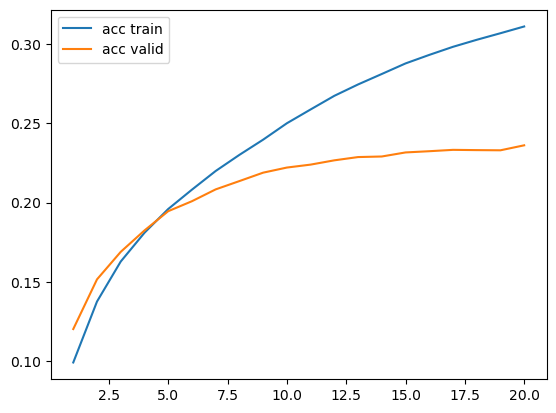

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='acc train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='acc valid')
plt.show()

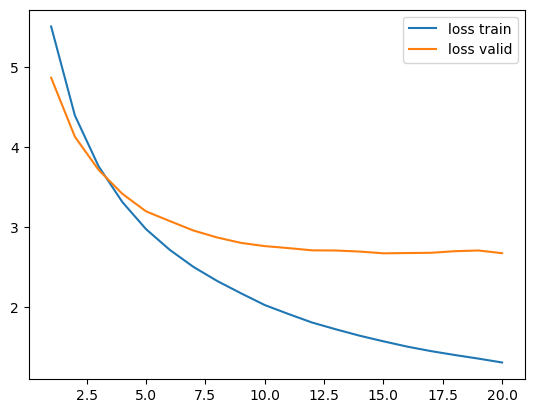

In [40]:
epoch_count = range(1, len(history1['loss']) + 1)
sns.lineplot(x=epoch_count,  y=history1['loss'], label='loss train')
sns.lineplot(x=epoch_count,  y=history1['val_loss'], label='loss valid')
plt.show()

### 5 - Inferencia

Step 1:
A deal is a deal -> Encoder -> enc(h1,c1)

enc(h1,c1) + \<sos> -> Decoder -> Un + dec(h1,c1)

step 2:
dec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)

step 3:
dec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)

step 4:
dec(h3,c3) + es -> Decoder -> un + dec(h4,c4)

step 5:
dec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)

step 6:
dec(h5,c5) + trato. -> Decoder -> \<eos> + dec(h6,c6)

In [41]:
# Cargo el mejor modelo guardado
model.load_state_dict(torch.load(model_filename))

<All keys matched successfully>

In [42]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

Funcion para el preprocesamiento de la oración de entrada

In [43]:
def prepare_input(input: str):
    print('Input:', input)
    integer_seq = input_tokenizer.texts_to_sequences([input])[0]
    print("Representacion en vector de tokens de ids", integer_seq)
    encoder_sequence = pad_sequences([integer_seq], maxlen=max_input_len)
    print("Padding del vector:", encoder_sequence)
    encoder_sequence_tensor = torch.from_numpy(encoder_sequence.astype(np.int32))
    return encoder_sequence_tensor


Prueba de traducción sobre la primer palabra de salida

In [44]:
input_test = "My mother say hi."
encoder_sequence_test_tensor = prepare_input(input_test)

# Se obtiene la salida del encoder (el estado oculto para el decoder)
prev_state = model.encoder(encoder_sequence_test_tensor.to(device))

# Se inicializa la secuencia de entrada al decoder como "<sos>"
target_seq = np.zeros((1, 1))
target_seq[0, 0] = word2idx_outputs['<sos>']
target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

# Se obtiene la primera palabra de la secuencia de salida del decoder
output, prev_state = model.decoder(target_seq_tensor.to(device), prev_state)

top1 = output.argmax(1)
idx = top1.item()
print("Index/token de salida:", idx)

word = idx2word_target[idx]
print("Palabra de salida:", word)

Input: My mother say hi.
Representacion en vector de tokens de ids [15, 187, 142, 1866]
Padding del vector: [[   0    0    0    0    0    0   15  187  142 1866]]
Index/token de salida: 22
Palabra de salida: mi


Función para traducir una oración completa

In [45]:
def translate_sentence(input_seq):
    encoder_sequence_tensor = prepare_input(input_seq)

    # Se transforma la sequencia de entrada a los stados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder"
    prev_state = model.encoder(encoder_sequence_tensor.to(device))

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

    # Se obtiene el indice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']
    
    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output, new_prev_state = model.decoder(target_seq_tensor.to(device), prev_state)
        top1 = output.argmax(1).view(-1, 1)
        idx = int(top1.cpu())

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar ídx a palabra
        word = ''        
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dado la ultimo prediccion
        prev_state = new_prev_state

        # Actualizar secuencia de entrada con la salida (re-alimentacion)
        target_seq_tensor = top1

    return ' '.join(output_sentence)

Pruena de traducción de la primer oración del array de entrada

In [46]:
input = input_sentences[0]
translation = translate_sentence(input)
print('-')
print('Input:', input)
print('Response:', translation)

Input: Tom sometimes falls asleep in class.
Representacion en vector de tokens de ids [5, 563, 2659, 620, 9, 542]
Padding del vector: [[   0    0    0    0    5  563 2659  620    9  542]]
-
Input: Tom sometimes falls asleep in class.
Response: tom parece que a menudo se dormido en clase


La traducción no fue perfecta, pero es bastante cercana, solo falta una palabra. Se termina entendiendo.

Prueba de una oración completa

In [47]:
input_test = "My mother say hi."
translation = translate_sentence(input_test)
print('Response:', translation)

Input: My mother say hi.
Representacion en vector de tokens de ids [15, 187, 142, 1866]
Padding del vector: [[   0    0    0    0    0    0   15  187  142 1866]]
Response: mi madre dijo a mary


Una parte de la traducción fue buena, pero en vez de hola tradujo que se dijo a algo a alguien. 

Prueba de una oración al azar del conjunto de entrada

In [48]:
i = np.random.choice(len(input_sentences))
input = input_sentences[i]
translation = translate_sentence(input)
print('-')
print('Input:', input)
print('Response:', translation)

Input: Tom turned up the TV.
Representacion en vector de tokens de ids [5, 482, 54, 2, 316]
Padding del vector: [[  0   0   0   0   0   5 482  54   2 316]]
-
Input: Tom turned up the TV.
Response: tom apagó la televisión


Esta frase era esperable que este bien traducida, ya que se tomó un input del archivo de entrada. Seguramente fue parte del entranamiento (aunque puede haber sido también del set te eval o test).

Pruebas con distintas oraciones

In [49]:
inputs = ["how you feel", "i'm feeling good", "my friend", "you are crazy", "are you crazy", "that is insane", "let's go home", 
          "A deal is a deal", "rest in peace", "a goal without a plan is just a wish", "never stop learning because life never stops teaching"]
for input in inputs:
    translation = translate_sentence(input)
    print('Response:', translation)
    print('----------')


Input: how you feel
Representacion en vector de tokens de ids [50, 3, 198]
Padding del vector: [[  0   0   0   0   0   0   0  50   3 198]]
Response: cómo te sientes
----------
Input: i'm feeling good
Representacion en vector de tokens de ids [26, 889, 72]
Padding del vector: [[  0   0   0   0   0   0   0  26 889  72]]
Response: estoy bien
----------
Input: my friend
Representacion en vector de tokens de ids [15, 245]
Padding del vector: [[  0   0   0   0   0   0   0   0  15 245]]
Response: soy mi amigo
----------
Input: you are crazy
Representacion en vector de tokens de ids [3, 20, 593]
Padding del vector: [[  0   0   0   0   0   0   0   3  20 593]]
Response: eres loco
----------
Input: are you crazy
Representacion en vector de tokens de ids [20, 3, 593]
Padding del vector: [[  0   0   0   0   0   0   0  20   3 593]]
Response: eres loco
----------
Input: that is insane
Representacion en vector de tokens de ids [18, 7, 1687]
Padding del vector: [[   0    0    0    0    0    0    0   18

En estas oraciones veo que:
* how you feel lo traduce muy bien.
* i'm feeling good también lo traduce bien, aunque normalmente lo expresamos distinto, pero puede depender de la traducción del dataset o del entrenamiento.
* my friend lo traduce regular, el soy sobra y cambia ligeramente el sentido de la oración
* you are crazy lo traduce bien
* are you crazy también lo traduce bien, aunque podría ser estas en lugar de eres. Al igual que uno de los comentarios anteriores, puede depender del dataset o del entrenamiento.
* that is insane no es la mejor traducción, pero puede ser una interpretación dentro de todo correcta. Al menos no apareció un opuesto a insane (como se observó en otras pruebas con otros hiperparámetros).
* let's go home también dentro de todo bien traducido, vamos, vete, no es lo mismo pero el sentido es correcto.
* A deal is a deal, aca probé con repetición de palabras, y el resultado no fue bueno. La traducción no tiene mucho sentido y la oración no esta muy bien formada.
* rest in peace no fue bien traducido, podría pensar que descansar en paz tiene alguna relación con dios, dependiendo el contexto y las creencias, pero no es la traducción esperada y no se interpreta el significado.
* a goal without a plan is just a wish, en la prueba con mayor cantidad de palabras, de una frase al azar de internet, la traducción no es buena y la oración no tiene mucho sentido.
* never stop learning because life never stops teaching, otra oración larga, el resultado es malo. La oración no tiene sentido, usa palabras contrapuestas y seguidas, no se entiende ni se interpreta significado.

### Búsqueda de mejor modelo
Creo la función de entrenamiento modificada para la búsqueda de hiperparámetros

In [50]:
def optimizer_fit(trial, model, train_loader, valid_loader, optimizer, criterion, device, epochs, clip, teacher_forcing_ratio):
    history = train(model, train_loader, valid_loader, optimizer, criterion, device, epochs, clip, teacher_forcing_ratio)
    best_train_loss = min(history["loss"])
    best_val_loss = min(history["val_loss"])
    best_train_acc = max(history["accuracy"])
    best_val_acc = max(history["val_accuracy"])
    print(f'trial {trial.number}. BEST: Train loss {best_train_loss:.3f} - Train accuracy {best_train_acc:.3f} '
          + f'- Valid Loss {best_val_loss:.3f} - Valid accuracy {best_val_acc:.3f}')
    return best_val_loss

Creamos el experimento de Optuna

In [ ]:
def champion_callback(study, frozen_trial):
    """
    Mostramos menos información, sino es demasiado verboso
    """
    # Obtener el mejor valor previo registrado en user_attrs
    winner = study.user_attrs.get("winner", None)
    
    # Si el valor actual supera al ganador anterior
    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        
        if winner:
            # Calcular la mejora porcentual
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value:.5f} with "
                f"{improvement_percent:.2f}% improvement"
            )
        else:
            # Primer ganador registrado
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value:.5f}")
    elif frozen_trial.number % 10 == 0:
        # Mostrar progreso cada 10 trials
        print(f"Trial {frozen_trial.number} with no changes.")

def objective(trial):

    lstm_size = trial.suggest_categorical("lstm_size", [64, 128, 256])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout_enc = trial.suggest_float("dropout_enc", 0.0, 0.5)
    dropout_dec = trial.suggest_float("dropout_dec", 0.0, 0.5)
    encoder = Encoder(embedding_glove_eng, dropout=dropout_enc, lstm_size=lstm_size, num_layers=num_layers)
    # Empty_Embeddings lo reinicializo en cada prueba ya que es el único que no tiene frezados los embeddings ya que debe aprenderlos
    decoder = Decoder(Empty_Embeddings(50, word2idx_outputs), dropout=dropout_dec, lstm_size=lstm_size, num_layers=num_layers)
    model = Seq2Seq(encoder, decoder, device)
    teacher_forcing_ratio = trial.suggest_float("teacher_forcing_ratio", 0.5, 1.0)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=0)  # Para clasificación multi categórica
    
    print(f"Trial {trial.number}. lstm_size {lstm_size} - num_layers {num_layers} - dropout_enc {dropout_enc:.2f} - dropout_dec {dropout_dec:.2f} " +
            f"- teacher_forcing_ratio {teacher_forcing_ratio:.2f}")
    score = optimizer_fit(trial, model, train_dataloader, val_dataloader, optimizer, criterion, device, epochs=15, 
                          clip=1.0, teacher_forcing_ratio=teacher_forcing_ratio)
    
    return score


In [ ]:
%pip install --quiet optuna
import optuna 
# Creamos un estudio de Optuna
# Optuna es un poco verboso, dejamos que solo nos muestre logs de errores
optuna.logging.set_verbosity(optuna.logging.ERROR)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10, callbacks=[champion_callback])

Trial 0. lstm_size 128 - num_layers 3 - dropout_enc 0.21 - dropout_dec 0.41 - embedding_enc fasttext - embedding_dec fasttext - teacher_forcing_ratio 0.70
Epoch: 1/20 - Train loss 5.752 - Train accuracy 0.091 - Valid Loss 5.307 - Valid accuracy 0.105 - Train PPX 314.693 - Valid PPX 201.691
Epoch: 2/20 - Train loss 4.983 - Train accuracy 0.116 - Valid Loss 4.722 - Valid accuracy 0.129 - Train PPX 145.844 - Valid PPX 112.446
Epoch: 3/20 - Train loss 4.481 - Train accuracy 0.134 - Valid Loss 4.316 - Valid accuracy 0.145 - Train PPX  88.297 - Valid PPX  74.859
Epoch: 4/20 - Train loss 4.123 - Train accuracy 0.146 - Valid Loss 4.051 - Valid accuracy 0.155 - Train PPX  61.752 - Valid PPX  57.434
Epoch: 5/20 - Train loss 3.855 - Train accuracy 0.154 - Valid Loss 3.851 - Valid accuracy 0.163 - Train PPX  47.221 - Valid PPX  47.027
Epoch: 6/20 - Train loss 3.624 - Train accuracy 0.162 - Valid Loss 3.682 - Valid accuracy 0.170 - Train PPX  37.504 - Valid PPX  39.716
Epoch: 7/20 - Train loss 3.44

In [53]:
import pandas as pd
# Visualizamos los mejores hiperparámetros encontrados
print("Best parameters:")
display(pd.DataFrame(study.best_params, index=['Value']))

Best parameters:


,lstm_size,num_layers,dropout_enc,dropout_dec,embedding_enc,embedding_dec,teacher_forcing_ratio
Value,256,2,0.116945,0.438111,glove,fasttext,0.997062


In [54]:
# Entrenamos el modelo y guardamos el mejor según validación
embedding_model_enc = embedding_glove_eng if (study.best_params["embedding_enc"] == "glove") else embedding_fasttext_eng
embedding_model_dec = Empty_Embeddings(50, word2idx_outputs) if (study.best_params["embedding_dec"] == "empty") else embedding_fasttext_esp
lstm_size = study.best_params["lstm_size"]
num_layers = study.best_params["num_layers"]
encoder = Encoder(embedding_model_enc, dropout=study.best_params["dropout_enc"], lstm_size=lstm_size, num_layers=num_layers)
decoder = Decoder(embedding_model_dec, dropout=study.best_params["dropout_dec"], lstm_size=lstm_size, num_layers=num_layers)
model = Seq2Seq(encoder, decoder, device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)  # Para clasificación multi categórica

model_filename_best = "best_translator.pt"
history1 = train(model, train_dataloader, val_dataloader, optimizer, criterion, device, epochs=20, 
                 teacher_forcing_ratio=study.best_params["teacher_forcing_ratio"], model_filename=model_filename_best)

# Al finalizar, cargo el mejor modelo
model.load_state_dict(torch.load(model_filename_best))

Epoch: 1/20 - Train loss 5.374 - Train accuracy 0.103 - Valid Loss 4.608 - Valid accuracy 0.128 - Train PPX 215.655 - Valid PPX 100.259
Epoch: 2/20 - Train loss 4.199 - Train accuracy 0.143 - Valid Loss 3.795 - Valid accuracy 0.164 - Train PPX  66.644 - Valid PPX  44.492
Epoch: 3/20 - Train loss 3.473 - Train accuracy 0.171 - Valid Loss 3.284 - Valid accuracy 0.189 - Train PPX  32.235 - Valid PPX  26.693
Epoch: 4/20 - Train loss 2.962 - Train accuracy 0.193 - Valid Loss 2.957 - Valid accuracy 0.207 - Train PPX  19.346 - Valid PPX  19.248
Epoch: 5/20 - Train loss 2.589 - Train accuracy 0.210 - Valid Loss 2.745 - Valid accuracy 0.220 - Train PPX  13.312 - Valid PPX  15.567
Epoch: 6/20 - Train loss 2.308 - Train accuracy 0.225 - Valid Loss 2.603 - Valid accuracy 0.230 - Train PPX  10.054 - Valid PPX  13.505
Epoch: 7/20 - Train loss 2.082 - Train accuracy 0.239 - Valid Loss 2.510 - Valid accuracy 0.237 - Train PPX   8.018 - Valid PPX  12.301
Epoch: 8/20 - Train loss 1.903 - Train accuracy 

<All keys matched successfully>

El modelo mejora. Obtuve loss en validación de 2.334 vs el modelo anterior con 2.674

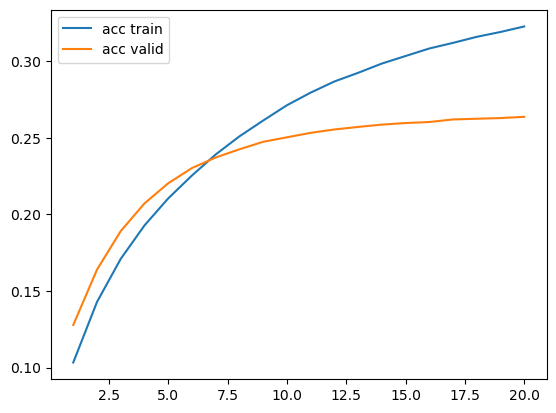

In [55]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='acc train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='acc valid')
plt.show()

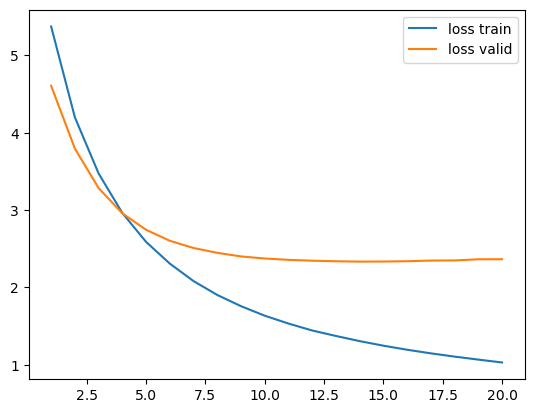

In [56]:
epoch_count = range(1, len(history1['loss']) + 1)
sns.lineplot(x=epoch_count,  y=history1['loss'], label='loss train')
sns.lineplot(x=epoch_count,  y=history1['val_loss'], label='loss valid')
plt.show()

En los gráficos se observa que la validación se estanca, y solo sigue mejorando el entrenamiento.  
El modelo empieza a tener overfitting.

Pruebas sobre el mejor modelo

In [57]:
inputs = ["how you feel", "i'm feeling good", "my friend", "you are crazy", "are you crazy", "that is insane", "let's go home", 
          "A deal is a deal", "rest in peace", "a goal without a plan is just a wish", "never stop learning because life never stops teaching"]
for input in inputs:
    translation = translate_sentence(input)
    print('Response:', translation)
    print('----------')


Input: how you feel
Representacion en vector de tokens de ids [50, 3, 198]
Padding del vector: [[  0   0   0   0   0   0   0  50   3 198]]
Response: ¡qué te sientes
----------
Input: i'm feeling good
Representacion en vector de tokens de ids [26, 889, 72]
Padding del vector: [[  0   0   0   0   0   0   0  26 889  72]]
Response: me siento bien
----------
Input: my friend
Representacion en vector de tokens de ids [15, 245]
Padding del vector: [[  0   0   0   0   0   0   0   0  15 245]]
Response: sos mi amigo
----------
Input: you are crazy
Representacion en vector de tokens de ids [3, 20, 593]
Padding del vector: [[  0   0   0   0   0   0   0   3  20 593]]
Response: eres loco
----------
Input: are you crazy
Representacion en vector de tokens de ids [20, 3, 593]
Padding del vector: [[  0   0   0   0   0   0   0  20   3 593]]
Response: estás loco
----------
Input: that is insane
Representacion en vector de tokens de ids [18, 7, 1687]
Padding del vector: [[   0    0    0    0    0    0    0

En estas oraciones veo que:
* how you feel lo traduce algo peor que el modelo anterior.
* i'm feeling good lo traduce bien.
* my friend lo traduce mejor.
* you are crazy lo traduce bien
* are you crazy también lo traduce bien, en este caso si uso la palabra estas en lugar de eres, mejoró.
* that is insane no hay cambios respecto a la traducción anterior.
* let's go home no hay cambios respecto a la traducción anterior.
* A deal is a deal, no es la mejor traducción, pero al menos ofrece algo que se puede interpretar.
* rest in peace, la traducción no es la esperada, pero al menos aparece la palabra paz.
* a goal without a plan is just a wish, la traducción sigue siendo mala.
* never stop learning because life never stops teaching, esta traducción también sigue siendo mala, aunque aparecen algunas palabras con mas sentido.

### 6 - Conclusión
El modelo logra traducir algunas oraciones con cierta coherencia.  
Con la búsqueda de hiperparámetros mejoran un poquito las traducciones, algunas siguen sin ser tan buenas.  
Es probable que el modelo este limitado por el recorte de sentencias y cantidad de palabras que se utilizaron.  
Esto seguro ocasiona que el modelo no conozca algunas palabras, que haya oraciones con palabras faltantes a la hora de entrenar, y de traducir.  
Se debería probar con mayor cantidad de palabras y oraciones, pero por cuestiones de tiempo y memoria se dificulta.  
El resultado no fue tan bueno como se esperaba, pero con las pruebas y cambios de hiperparámetros se llegó a algo minimamente aceptable.
